# Análisis de Dataset de Spotify



#### El objetivo primordial de este conjunto de datos es identificar y analizar los factores que diferencian a las canciones populares de las no populares dentro de la plataforma Spotify.

In [3]:
from pycaret import regression
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
datos = pd.read_csv("spotify_data.csv")
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   energy                    1686 non-null   float64
 1   tempo                     1686 non-null   float64
 2   danceability              1686 non-null   float64
 3   playlist_genre            1686 non-null   object 
 4   loudness                  1686 non-null   float64
 5   liveness                  1686 non-null   float64
 6   valence                   1686 non-null   float64
 7   track_artist              1686 non-null   object 
 8   time_signature            1686 non-null   int64  
 9   speechiness               1686 non-null   float64
 10  track_popularity          1686 non-null   int64  
 11  track_href                1686 non-null   object 
 12  uri                       1686 non-null   object 
 13  track_album_name          1685 non-null   object 
 14  playlist

#### La variable de salida o estimación es track_popularity

## Tratamiento de Datos

### Tratamiento de valores nulos

In [5]:
datos.isnull().sum()

energy                      0
tempo                       0
danceability                0
playlist_genre              0
loudness                    0
liveness                    0
valence                     0
track_artist                0
time_signature              0
speechiness                 0
track_popularity            0
track_href                  0
uri                         0
track_album_name            1
playlist_name               0
analysis_url                0
track_id                    0
track_name                  0
track_album_release_date    0
instrumentalness            0
track_album_id              0
mode                        0
key                         0
duration_ms                 0
acousticness                0
id                          0
playlist_subgenre           0
type                        0
playlist_id                 0
dtype: int64

### Tratamiento de valores atípicos

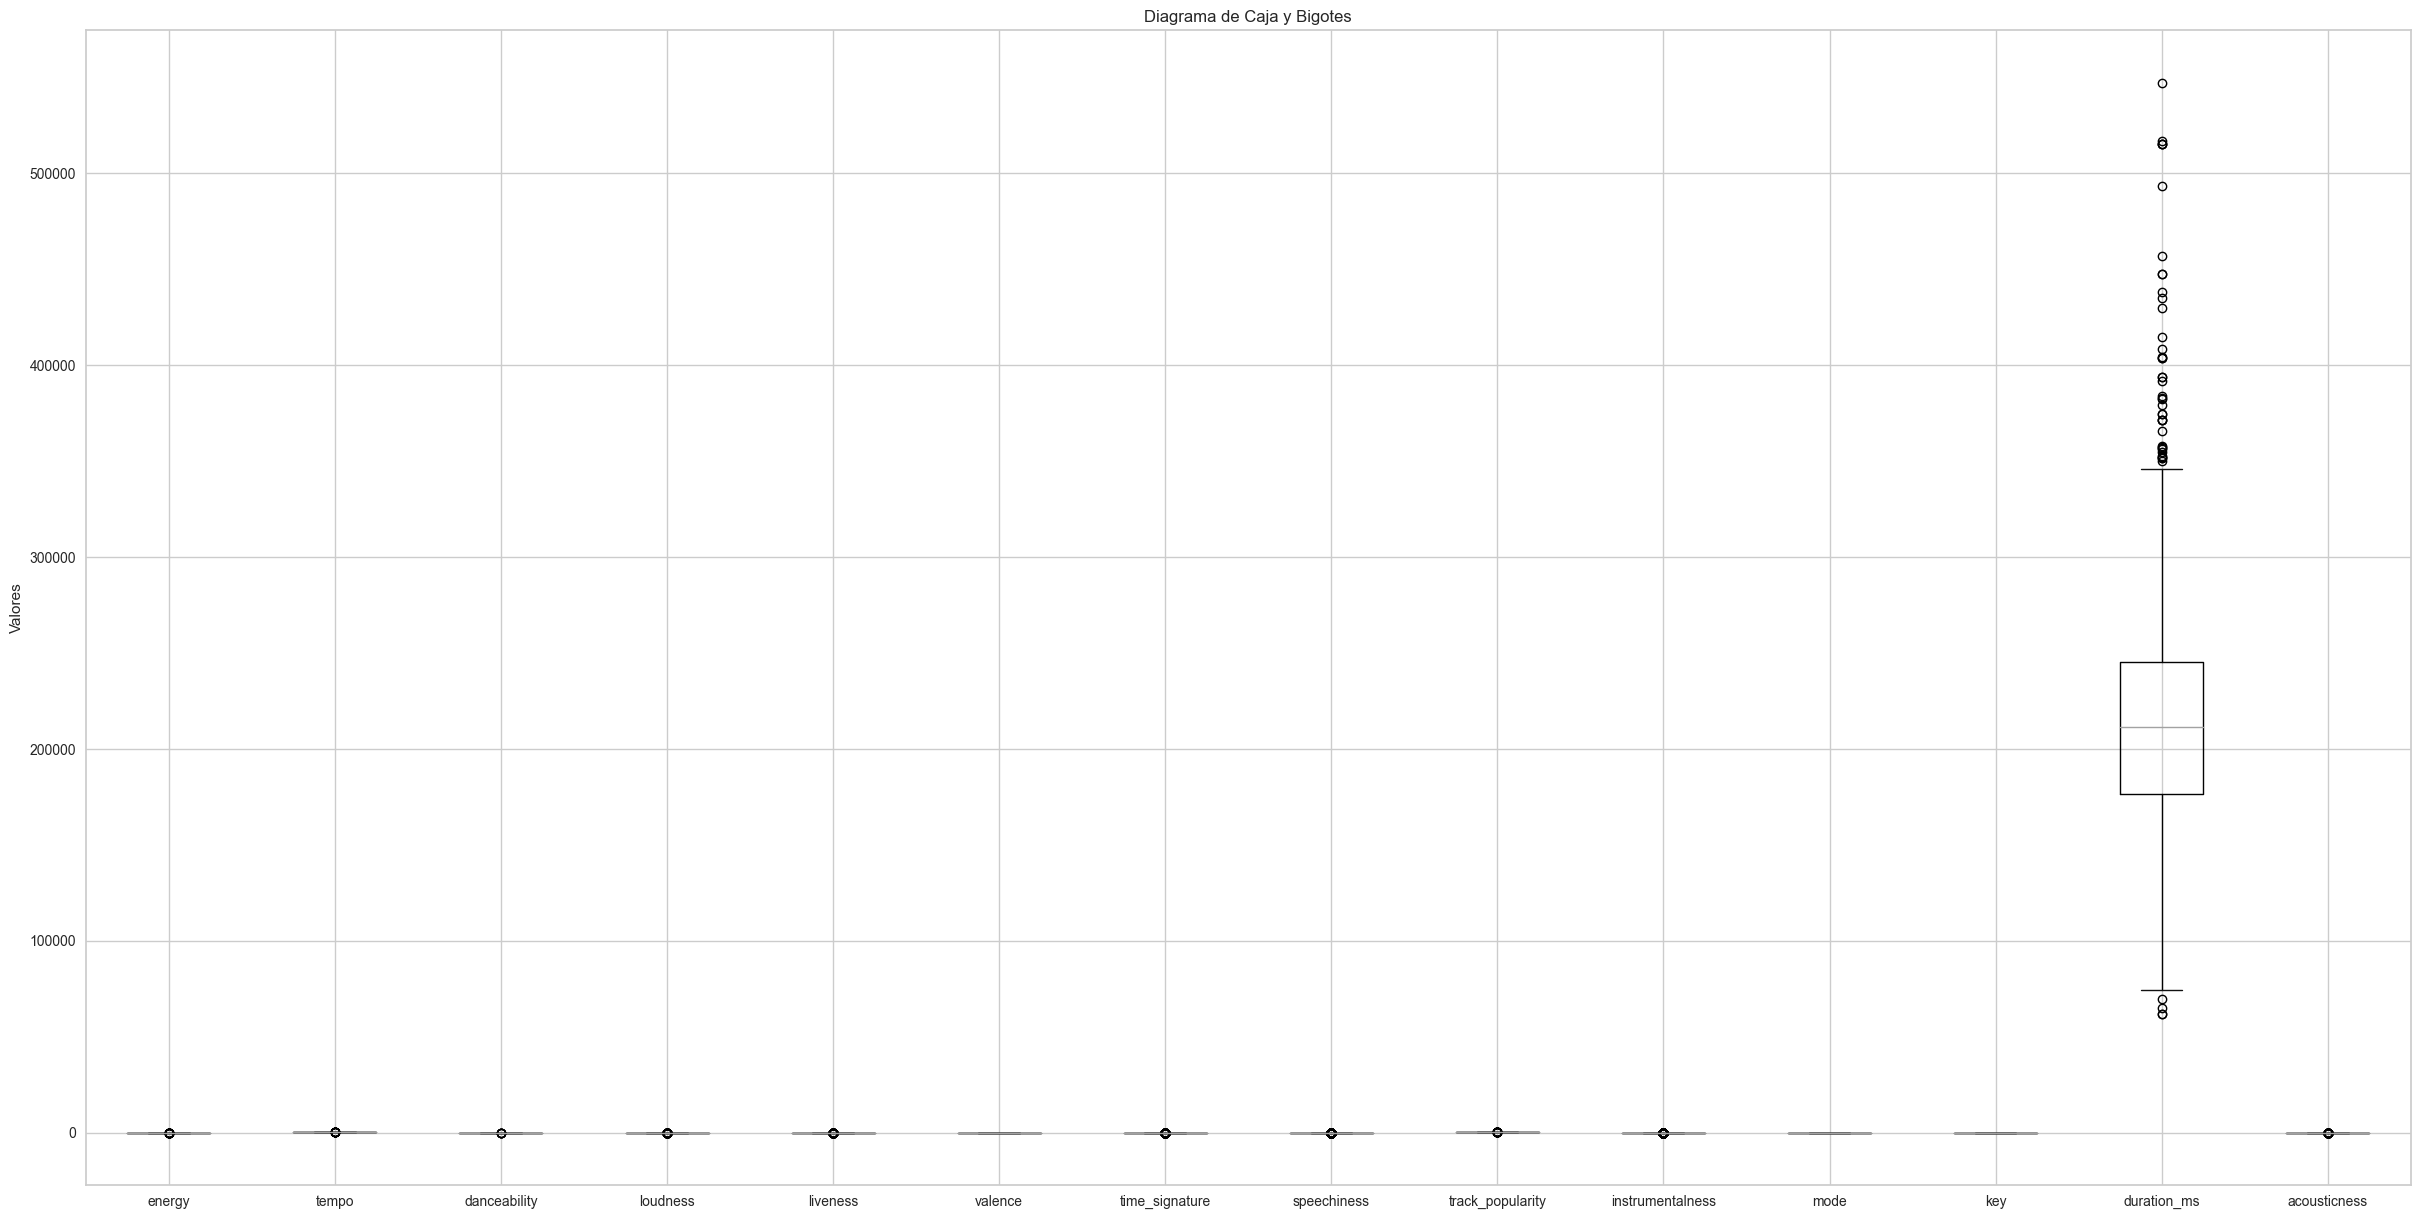

In [6]:
plt.figure(figsize=(30, 15))
datos.boxplot(column=['energy','tempo','danceability','loudness','liveness','valence','time_signature','speechiness','track_popularity','instrumentalness','mode','key','duration_ms','acousticness'])
plt.title('Diagrama de Caja y Bigotes')
plt.ylabel('Valores')
plt.show()

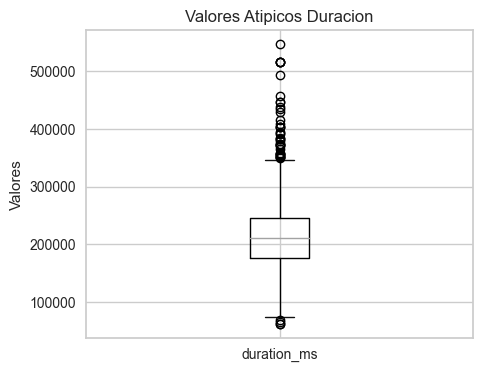

In [7]:
plt.figure(figsize=(5, 4))
datos.boxplot(column=['duration_ms'])
plt.title('Valores Atipicos Duracion')
plt.ylabel('Valores')
plt.show()

##  Ingeniería de características

In [8]:
# Convertimos a datetime y serparamos por distintas columnas con la extracción
# 'format=mixed' detecta si viene solo el año o la fecha completa
datos['track_album_release_date']=pd.to_datetime(datos['track_album_release_date'],format='mixed')
datos['year_album_release']=datos['track_album_release_date'].dt.year
datos['month_album_release']=datos['track_album_release_date'].dt.month
datos['day_album_release']=datos['track_album_release_date'].dt.day
# 3. Importante: Para las fechas que solo tenían año, el mes y día quedarán como NaN.
# Los llenamos con 1 (enero, día 1) para que no den error en el modelo.
datos['month_album_release'] = datos['month_album_release'].fillna(1).astype(int)
datos['day_album_release'] = datos['day_album_release'].fillna(1).astype(int)
datos[['year_album_release', 'month_album_release', 'day_album_release','track_album_release_date']]

,year_album_release,month_album_release,day_album_release,track_album_release_date
0,2024,8,16,2024-08-16
1,2024,5,17,2024-05-17
2,2024,10,18,2024-10-18
3,2024,8,23,2024-08-23
4,2024,10,18,2024-10-18
...,...,...,...,...
1681,2022,12,6,2022-12-06
1682,2022,7,14,2022-07-14
1683,2023,3,30,2023-03-30
1684,2022,4,29,2022-04-29


## Selección de características.

In [9]:
#Se eliminará todas las columnas relacionadas con el id ya que no me funcionará para mi entrenamiento
# Lista las columnas que eliminaré
columnas_a_eliminar = ['track_album_release_date', 'uri','analysis_url', 'track_id','track_album_id','id','playlist_id']

# El parámetro axis=1 indica que son columnas, inplace=True guarda los cambios
datos.drop(columns=columnas_a_eliminar, inplace=True)

In [11]:
datos.drop(columns='track_href',inplace=True)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   energy               1686 non-null   float64
 1   tempo                1686 non-null   float64
 2   danceability         1686 non-null   float64
 3   playlist_genre       1686 non-null   object 
 4   loudness             1686 non-null   float64
 5   liveness             1686 non-null   float64
 6   valence              1686 non-null   float64
 7   track_artist         1686 non-null   object 
 8   time_signature       1686 non-null   int64  
 9   speechiness          1686 non-null   float64
 10  track_popularity     1686 non-null   int64  
 11  track_album_name     1685 non-null   object 
 12  playlist_name        1686 non-null   object 
 13  track_name           1686 non-null   object 
 14  instrumentalness     1686 non-null   float64
 15  mode                 1686 non-null   i

In [15]:
reg1 = regression.setup(
    data = datos,
    target = 'track_popularity',
    numeric_imputation="knn", #Tratamiento  valores nulos
    remove_outliers = True, # Eliminando valores atípicos
    outliers_threshold=0.3,
    train_size = 0.75, # División de datos en entrenamiento un 75%
    # Solo dejamos las categorias que aportan patrones 
    ignore_features = ["track_name", "track_album_name", "playlist_name"],
    categorical_features = ["playlist_genre", "track_artist","playlist_subgenre","type"], # Especificando las variables categóricas
    polynomial_features = True, # Realizando Ingeniería de características con características polinomiales
    polynomial_degree = 2, # Grado máximo del polinomio
    rare_to_value = 0.1, # Ingeniería de característica, combinando valores raros en una sola columna
    feature_selection = True, # Activando selección de características para que seleccione las más importantes
    n_features_to_select = 8, # Aquí se coloca el porcentaje de características o la cantidad de características que se mantienen
    pca = True, # Activamos PCA para generar un resumen de la información
    pca_components = 10, # Especificamos el número de componentes a generar en el resumen
    normalize = True, # Activamos la normalización
    normalize_method = "zscore" # Estandarización
    )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 885, number of used features: 10
[LightGBM] [Info] Start training from score 76.275706


,Description,Value
0,Session id,8373
1,Target,track_popularity
2,Target type,Regression
3,Original data shape,"(1686, 24)"
4,Transformed data shape,"(1307, 9)"
5,Transformed train set shape,"(885, 9)"
6,Transformed test set shape,"(422, 9)"
7,Ignore features,3
8,Numeric features,16
9,Categorical features,4


In [16]:
reg1.dataset_transformed

,pca0,pca1,pca2,pca5,pca6,pca7,pca8,pca9,track_popularity
584,0.812241,5.365839,3.846963,2.744549,-5.013983,-7.684824,3.113928,-4.848545,69
351,4.497401,2.879823,-3.532887,-2.788257,1.921752,-2.745372,-6.697192,-0.523763,78
558,6.781831,-0.576467,1.880319,2.207530,-1.535053,-4.506533,0.587907,5.239196,72
483,2.440177,6.721123,-1.978975,-4.087031,-3.310958,6.222840,-5.037508,0.947372,83
488,7.551902,3.986200,-2.629830,-1.454324,-1.849397,1.981327,2.356487,0.601204,82
...,...,...,...,...,...,...,...,...,...
1016,-17.802379,5.177665,19.132071,-0.057778,-8.534665,2.257805,-6.074432,-0.887566,73
146,2.907250,-3.917982,-9.288391,3.785433,4.654515,-5.952048,-1.034327,-3.105388,92
799,-5.682286,11.915016,12.992798,-3.275213,0.314445,1.885236,-2.722931,-5.094659,72
1452,6.418325,-10.567696,-5.438158,5.836036,-2.995777,-6.729779,-2.594315,2.578570,73
